In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tkan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Flatten, GRU, Dropout

from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from tkan import TKAN

import time

keras.utils.set_random_seed(1)

early_stopping_callback = lambda : keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=10,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=6,
)
lr_callback = lambda : keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=5,
    mode="min",
    min_delta=0.00001,
    min_lr=1e-10,
    verbose=0,
)
callbacks = lambda : [early_stopping_callback(), lr_callback(), keras.callbacks.TerminateOnNaN()]

In [ ]:
class MinMaxScaler:
    def __init__(self, feature_axis=None, minmax_range=(0, 1)):
        """
        Initialize the MinMaxScaler.
        Args:
        feature_axis (int, optional): The axis that represents the feature dimension if applicable.
                                      Use only for 3D data to specify which axis is the feature axis.
                                      Default is None, automatically managed based on data dimensions.
        """
        self.feature_axis = feature_axis
        self.min_ = None
        self.max_ = None
        self.scale_ = None
        self.minmax_range = minmax_range # Default range for scaling (min, max)

    def fit(self, X):
        """
        Fit the scaler to the data based on its dimensionality.
        Args:
        X (np.array): The data to fit the scaler on.
        """
        if X.ndim == 3 and self.feature_axis is not None:  # 3D data
            axis = tuple(i for i in range(X.ndim) if i != self.feature_axis)
            self.min_ = np.min(X, axis=axis)
            self.max_ = np.max(X, axis=axis)
        elif X.ndim == 2:  # 2D data
            self.min_ = np.min(X, axis=0)
            self.max_ = np.max(X, axis=0)
        elif X.ndim == 1:  # 1D data
            self.min_ = np.min(X)
            self.max_ = np.max(X)
        else:
            raise ValueError("Data must be 1D, 2D, or 3D.")

        self.scale_ = self.max_ - self.min_
        return self

    def transform(self, X):
        """
        Transform the data using the fitted scaler.
        Args:
        X (np.array): The data to transform.
        Returns:
        np.array: The scaled data.
        """
        X_scaled = (X - self.min_) / self.scale_
        X_scaled = X_scaled * (self.minmax_range[1] - self.minmax_range[0]) + self.minmax_range[0]
        return X_scaled

    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        Args:
        X (np.array): The data to fit and transform.
        Returns:
        np.array: The scaled data.
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Inverse transform the scaled data to original data.
        Args:
        X_scaled (np.array): The scaled data to inverse transform.
        Returns:
        np.array: The original data scale.
        """
        X = (X_scaled - self.minmax_range[0]) / (self.minmax_range[1] - self.minmax_range[0])
        X = X * self.scale_ + self.min_
        return X

In [ ]:
def history_plot(history, model_id, n_ahead):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  fig = plt.gcf()
  plt.show()
  fig.savefig(f'{model_id}_{n_ahead}_loss.png')

Чтение данных из csv

# С нормализацией, полный ETTh1

In [ ]:
def prepare_sequences(df, n_history, n_future):
    X, y = [], []
   
    # Iterate through the DataFrame to create sequences of n_history length
    for i in range(n_history, len(df) - n_future + 1):
        X.append(df.iloc[i - n_history:i].values) # all cols, n_history rows
        y.append(df.iloc[i:i + n_future].values) # all cols

    X, y = np.array(X), np.array(y)

    return X, y

def generate_data(_df, sequence_length, data_split, n_ahead = 1):
    train_len, val_len, test_len = data_split

    # Prepare sequences
    X, y = prepare_sequences(_df, sequence_length, n_ahead)

    # Split the dataset into training and testing sets
    X_train_un, X_val_un, X_test_un = X[:train_len], X[train_len:train_len + val_len], X[train_len + val_len:]
    y_train_un, y_val_un, y_test_un = y[:train_len], y[train_len:train_len + val_len], y[train_len + val_len:]

    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_un)
    X_val = X_scaler.transform(X_val_un)
    X_test = X_scaler.transform(X_test_un)

    y_train = X_scaler.fit_transform(y_train_un)
    y_val = X_scaler.transform(y_val_un)
    y_test = X_scaler.transform(y_test_un)

    n_output = y_train.shape[1] * y_train.shape[2]
    y_train = y_train.reshape((y_train.shape[0], n_output))
    y_val = y_val.reshape((y_val.shape[0], n_output))
    y_test = y_test.reshape((y_test.shape[0], n_output))
    return X_train, X_val, X_test, y_train, y_val, y_test

# ECL dataset

In [ ]:
data = pd.read_csv("ECL.csv")
data = data.rename(columns={'date': 'timestamp'})
variable = data.iloc[:, 1:].to_numpy()

In [ ]:
print(variable.shape)

(26304, 321)


In [ ]:
data_df = pd.DataFrame(variable)
display(data_df)

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,351.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
26300,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,327.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
26301,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,283.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0
26302,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,292.0,...,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0,2719.0


## ECL, 12 hours

Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_24 (TKAN)                  │ (None, 48, 50)         │     1,004,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_25 (TKAN)                  │ (None, 50)             │        20,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 3852)           │       196,452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,236 (4.66 MB)

 Trainable params: 1,217,826 (4.65 MB)

 Non-trainable params: 3,410 (13.32 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - loss: 0.1313 - val_loss: 0.0201 - learning_rate: 1.0000e-04
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0245 - val_loss: 0.0200 - learning_rate: 1.0000e-04
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0227 - val_loss: 0.0162 - learning_rate: 1.0000e-04
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0184 - val_loss: 0.0126 - learning_rate: 1.0000e-04
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0149 - val_loss: 0.0114 - learning_rate: 1.0000e-04
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0135 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0129 - val_loss: 0.0103 - learning_rate: 1.0000e-04
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0126 - val_loss: 0.0107 - learning_rate: 1.0000e-04
Epoch 9/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0124 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                    │ (None, 48, 50)         │        55,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3852)           │       196,452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,702 (1.02 MB)

 Trainable params: 267,702 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1231 - val_loss: 0.0220 - learning_rate: 1.0000e-04
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0274 - val_loss: 0.0220 - learning_rate: 1.0000e-04
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0272 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0261 - val_loss: 0.0183 - learning_rate: 1.0000e-04
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0220 - val_loss: 0.0142 - learning_rate: 1.0000e-04
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0166 - val_loss: 0.0115 - learning_rate: 1.0000e-04
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0138 - val_loss: 0.0112 - learning_rate: 1.0000e-04
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0131 - val_loss: 0.0112 - learning_rate: 1.0000e-04
Epoch 9/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0128 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 48, 50)         │        74,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3852)           │       196,452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,052 (1.11 MB)

 Trainable params: 291,052 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1312 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0276 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0273 - val_loss: 0.0214 - learning_rate: 1.0000e-04
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0264 - val_loss: 0.0192 - learning_rate: 1.0000e-04
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0241 - val_loss: 0.0172 - learning_rate: 1.0000e-04
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0219 - val_loss: 0.0150 - learning_rate: 1.0000e-04
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0189 - val_loss: 0.0119 - learning_rate: 1.0000e-04
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0152 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 9/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0134 - val_loss:

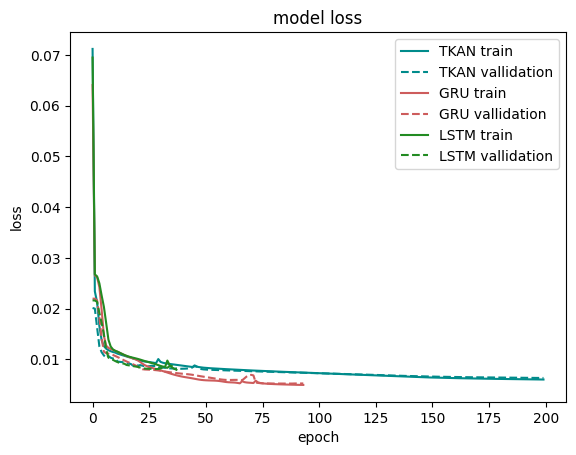

R2, RMSE, MAE scores
Means:


,TKAN,GRU,LSTM
12,0.251285,0.192938,0.213038


,TKAN,GRU,LSTM
12,0.080921,0.07558,0.106267


,TKAN,GRU,LSTM
12,0.063136,0.058302,0.084018


Std:


,TKAN,GRU,LSTM
12,0.0,0.0,0.0


,TKAN,GRU,LSTM
12,0.0,0.0,0.0


,TKAN,GRU,LSTM
12,0.0,0.0,0.0


Training Times


,TKAN,GRU,LSTM
12,1778.360179,251.268569,106.208195


,TKAN,GRU,LSTM
12,0.0,0.0,0.0


In [ ]:
RUNS_NUM = 1
BATCH_SIZE = 64
N_MAX_EPOCHS = 200
lr = 0.0001

n_aheads = [12]
data_split=[18412, 2632, 5260]
sequence_length = 48

models = ["TKAN", "GRU", "LSTM",]
colors = ['darkcyan', 'indianred', 'forestgreen']
hidden_size = [50]

results_r2 = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
results_rmse = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
results_mae = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
time_results = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}

for n_ahead in n_aheads:
    X_train, X_val, X_test, y_train, y_val, y_test = generate_data(data_df, sequence_length, data_split, n_ahead)

    for color, model_id in zip(colors, models):
        for run in range(RUNS_NUM):

            if model_id == 'TKAN':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    TKAN(hidden_size[0], return_sequences=True),
                    TKAN(hidden_size[0], sub_kan_output_dim = 20, sub_kan_input_dim = 20, return_sequences=False),
                    Dense(units=y_train.shape[1], activation='linear')
                ], name = model_id)
            elif model_id == 'GRU':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    GRU(hidden_size[0], return_sequences=True),
                    GRU(hidden_size[0], return_sequences=False),
                    Dense(units=y_train.shape[1], activation='linear')
                ], name = model_id)
            elif model_id == 'LSTM':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    LSTM(hidden_size[0], return_sequences=True),
                    LSTM(hidden_size[0], return_sequences=False),
                    Dense(units=y_train.shape[1], activation='linear')
                ], name = model_id)
            else:
                raise ValueError

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss=['mean_squared_error'], jit_compile=True)
            if run==0:
                model.summary()

            # Fit the model
            start_time = time.time()
            history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_data=(X_val, y_val), callbacks=callbacks(), shuffle=False, verbose = 1)
            end_time = time.time()
            time_results[model_id][n_ahead].append(end_time - start_time)

            # Evaluate the model on the test set
            results = model.evaluate(X_test, y_test)
            print('test loss:', results)
            preds = model.predict(X_test, verbose=False)
            r2 = r2_score(y_true=y_test, y_pred=preds)
            rmse = root_mean_squared_error(y_true=y_test, y_pred=preds)
            mae = mean_absolute_error(y_true=y_test, y_pred=preds)
            print(f"{end_time - start_time}, r2={r2}, rmse={rmse}, mae={mae}")

            results_r2[model_id][n_ahead].append(r2)
            results_rmse[model_id][n_ahead].append(rmse)
            results_mae[model_id][n_ahead].append(mae)
            # history_plot(history, model_id, n_ahead)
            plt.plot(history.history['loss'], label=f'{model_id} train', color=color)
            plt.plot(history.history['val_loss'], label=f'{model_id} vallidation', color=color, linestyle='--')

            del model
            del optimizer

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    fig = plt.gcf()
    plt.show()
    fig.savefig(f'{hidden_size[0]}_{n_ahead}_loss.png')


print('R2, RMSE, MAE scores')
print('Means:')
display(pd.DataFrame({model_id: {n_ahead: np.mean(results_r2[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_r2.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.mean(results_rmse[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_rmse.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.mean(results_mae[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_mae.keys()}))
print('Std:')
display(pd.DataFrame({model_id: {n_ahead: np.std(results_r2[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_r2.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.std(results_rmse[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_rmse.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.std(results_mae[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_mae.keys()}))
print('Training Times')
display(pd.DataFrame({model_id: {n_ahead: np.mean(time_results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in time_results.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.std(time_results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in time_results.keys()}))

## TKAN dropout, 24 hours

Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_4 (TKAN)                   │ (None, 48, 50)         │     1,004,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_5 (TKAN)                   │ (None, 50)             │        20,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7704)           │       392,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417,688 (5.41 MB)

 Trainable params: 1,414,278 (5.40 MB)

 Non-trainable params: 3,410 (13.32 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - loss: 0.0512 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0237 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0124 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0105 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0102 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0100 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0099 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0099 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 9/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0099 - val_loss: 0.0103 - learning_rate

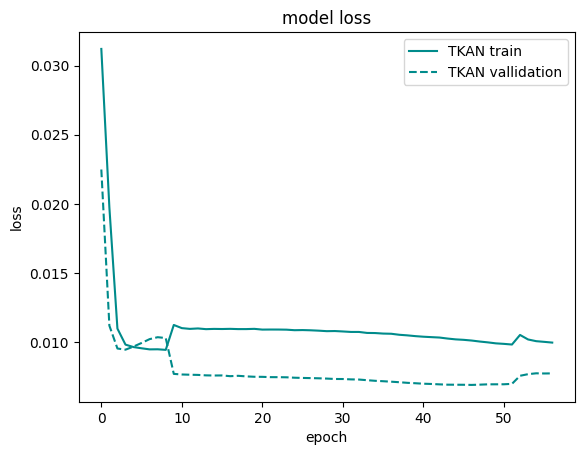

R2, RMSE, MAE scores
Means:


,TKAN
24,0.334381


,TKAN
24,0.097827


,TKAN
24,0.075497


Std:


,TKAN
24,0.0


,TKAN
24,0.0


,TKAN
24,0.0


Training Times


,TKAN
24,530.609071


,TKAN
24,0.0


In [ ]:
RUNS_NUM = 1
BATCH_SIZE = 64
N_MAX_EPOCHS = 200
lr = 0.001

n_aheads = [24]
data_split=[18412, 2632, 5260]
sequence_length = 48

models = ["TKAN"]
colors = ['darkcyan', 'indianred', 'forestgreen']
hidden_size = [50]

results_r2 = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
results_rmse = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
results_mae = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
time_results = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}

for n_ahead in n_aheads:
    X_train, X_val, X_test, y_train, y_val, y_test = generate_data(data_df, sequence_length, data_split, n_ahead)

    for color, model_id in zip(colors, models):
        for run in range(RUNS_NUM):

            if model_id == 'TKAN':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    TKAN(hidden_size[0], return_sequences=True),
                    Dropout(rate=0.1),
                    TKAN(hidden_size[0], sub_kan_output_dim = 20, sub_kan_input_dim = 20, return_sequences=False),
                    Dropout(rate=0.1),
                    Dense(units=y_train.shape[1], activation='linear')
                ], name = model_id)
            elif model_id == 'GRU':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    GRU(hidden_size[0], return_sequences=True),
                    GRU(hidden_size[0], return_sequences=False),
                    Dense(units=y_train.shape[1], activation='linear')
                ], name = model_id)
            elif model_id == 'LSTM':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    LSTM(hidden_size[0], return_sequences=True),
                    LSTM(hidden_size[0], return_sequences=False),
                    Dense(units=y_train.shape[1], activation='linear')
                ], name = model_id)
            else:
                raise ValueError

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss=['mean_squared_error'], jit_compile=True)
            if run==0:
                model.summary()

            # Fit the model
            start_time = time.time()
            history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_data=(X_val, y_val), callbacks=callbacks(), shuffle=False, verbose = 1)
            end_time = time.time()
            time_results[model_id][n_ahead].append(end_time - start_time)

            # Evaluate the model on the test set
            results = model.evaluate(X_test, y_test)
            print('test loss:', results)
            preds = model.predict(X_test, verbose=False)
            r2 = r2_score(y_true=y_test, y_pred=preds)
            rmse = root_mean_squared_error(y_true=y_test, y_pred=preds)
            mae = mean_absolute_error(y_true=y_test, y_pred=preds)
            print(f"{end_time - start_time}, r2={r2}, rmse={rmse}, mae={mae}")

            results_r2[model_id][n_ahead].append(r2)
            results_rmse[model_id][n_ahead].append(rmse)
            results_mae[model_id][n_ahead].append(mae)
            # history_plot(history, model_id, n_ahead)
            plt.plot(history.history['loss'], label=f'{model_id} train', color=color)
            plt.plot(history.history['val_loss'], label=f'{model_id} vallidation', color=color, linestyle='--')

            del model
            del optimizer

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    fig = plt.gcf()
    plt.show()
    fig.savefig(f'{hidden_size[0]}_{n_ahead}_loss_dropout.png')


print('R2, RMSE, MAE scores')
print('Means:')
display(pd.DataFrame({model_id: {n_ahead: np.mean(results_r2[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_r2.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.mean(results_rmse[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_rmse.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.mean(results_mae[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_mae.keys()}))
print('Std:')
display(pd.DataFrame({model_id: {n_ahead: np.std(results_r2[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_r2.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.std(results_rmse[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_rmse.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.std(results_mae[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_mae.keys()}))
print('Training Times')
display(pd.DataFrame({model_id: {n_ahead: np.mean(time_results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in time_results.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.std(time_results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in time_results.keys()}))